In [1]:
import pandas as pd
import psycopg2

import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

from utils import glm_marginal_effect, compute_pca, calc_total_effect

In [2]:
connection = psycopg2.connect(host="localhost", dbname="postgres", user="postgres", port=5432)

In [2]:
github_data = pd.read_csv("../github_data.csv")

In [4]:
data = github_data

In [5]:
data['giniXavg_min_path'] = data['gini_coefficient'] * data['avg_min_path']
data['giniXclustering'] = data['gini_coefficient'] * data['avg_clustering']
data['clusteringXavg_min_path'] = data['avg_clustering'] * data['avg_min_path']

data['giniXavg_min_pathXcrowd_pct'] = data['gini_coefficient'] * data['avg_min_path'] * data['crowd_pct']
data['giniXclusteringXcrowd_pct'] = data['gini_coefficient'] * data['avg_clustering'] * data['crowd_pct']
data['clusateringXavg_min_pathXcrowd_pct'] = data['avg_clustering'] * data['avg_min_path'] * data['crowd_pct']

data['avg_clustering_2'] = data['avg_clustering']**2
data['avg_min_path_2'] = data['avg_min_path']**2
data['gini_coefficient_2'] = data['gini_coefficient']**2

data['crowd_pct_3'] = data['crowd_pct']**3

In [6]:
data.columns

Index(['package', 'organization', 'topic_0', 'topic_1', 'topic_2', 'topic_3',
       'topic_4', 'topic_5', 'topic_6', 'topic_7', 'topic_8', 'topic_9',
       'topic_10', 'topic_11', 'topic_12', 'topic_13', 'topic_14', 'topic_15',
       'topic_16', 'topic_17', 'topic_18', 'topic_19', 'topic_20', 'topic_21',
       'topic_22', 'topic_23', 'package_id', 'duration_median', 'project_age',
       'num_users', 'crowd_pct', 'crowd', 'total_issues', 'gini_coefficient',
       'avg_clustering', 'avg_min_path', 'nodes', 'total_contributors',
       'avg_comments', 'avg_first_comment', 'avg_active_time', 'crowd_pct_2',
       'issues_over_time', 'avg_clusteringXcrowd_pct',
       'avg_min_pathXcrowd_pct', 'gini_coefficientXcrowd_pct',
       'issues_per_user', 'avg_retention_time', 'giniXavg_min_path',
       'giniXclustering', 'clusteringXavg_min_path',
       'giniXavg_min_pathXcrowd_pct', 'giniXclusteringXcrowd_pct',
       'clusteringXavg_min_pathXcrowd_pct', 'avg_clustering_2',
       'avg_m

In [12]:
data['log_total_issues'] = np.log(data['total_issues'])
data['log_total_contributors'] = np.log(data['total_contributors'])

In [11]:
formula = """
log_total_issues ~  total_contributors
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.OLS(y, X) #, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
#print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

3
                            OLS Regression Results                            
Dep. Variable:           total_issues   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.419
Method:                 Least Squares   F-statistic:                     203.0
Date:                Wed, 02 Sep 2020   Prob (F-statistic):           5.38e-67
Time:                        00:54:03   Log-Likelihood:                -3371.7
No. Observations:                 562   AIC:                             6749.
Df Residuals:                     559   BIC:                             6762.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             36.5448     

(0.0, 200.0)

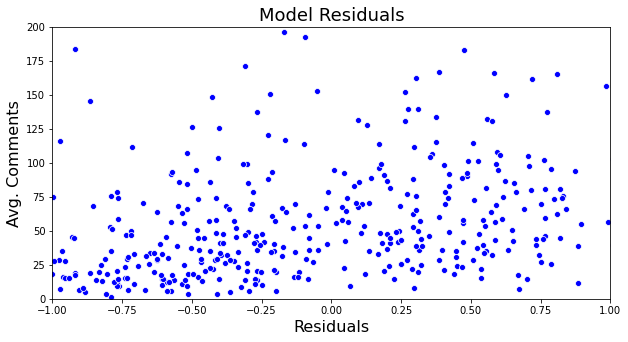

In [75]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['avg_retention_time'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Avg. Comments', fontsize=16)
plt.xlim([-1, 1])
plt.ylim([0, 200])

Text(0, 0.5, 'Count')

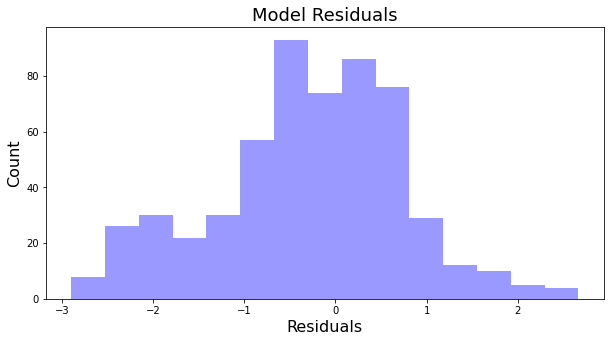

In [87]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe_scaled, kde=False, color='blue', bins=15)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Count', fontsize=16)
#plt.xlim([-2.2, 2.2])

In [79]:
data['avg_retention_time_resid'] = res.resid_anscombe_scaled
formula = """
avg_retention_time_resid ~ -1 + crowd_pct + crowd_pct_2 + crowd_pct_3 +
    gini_coefficient + avg_clustering +
    giniXavg_min_path + giniXclustering + 
    avg_min_path_2 + avg_active_time + total_issues + project_age + total_contributors
"""
y_res, X_res = dmatrices(formula,
                         data=data, return_type='dataframe')
residual_mod = sm.OLS(y_res, X_res)
residual_res = residual_mod.fit()
print(residual_res.summary())

                                    OLS Regression Results                                   
Dep. Variable:     avg_retention_time_resid   R-squared (uncentered):                   0.091
Model:                                  OLS   Adj. R-squared (uncentered):              0.071
Method:                       Least Squares   F-statistic:                              4.583
Date:                      Tue, 01 Sep 2020   Prob (F-statistic):                    4.31e-07
Time:                              23:37:57   Log-Likelihood:                         -809.51
No. Observations:                       562   AIC:                                      1643.
Df Residuals:                           550   BIC:                                      1695.
Df Model:                                12                                                  
Covariance Type:                  nonrobust                                                  
                         coef    std err          t      P>|

Text(0.5, 0, 'Crowd Source Percentage')

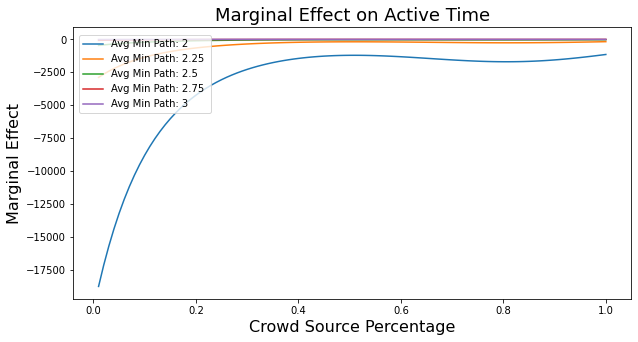

In [80]:
plt.figure(figsize=(10, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_min_path=avg_min_path)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Active Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

Text(0.5, 0, 'Crowd Source Percentage')

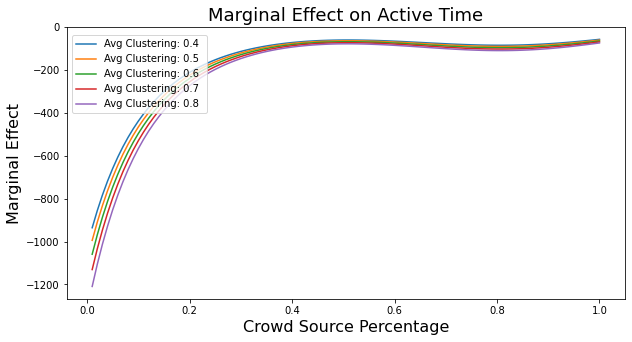

In [81]:
plt.figure(figsize=(10, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Active Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

Text(0.5, 0, 'Crowd Source Percentage')

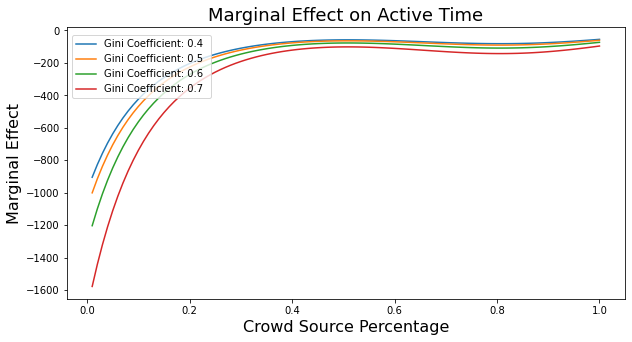

In [82]:
plt.figure(figsize=(10, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       gini_coefficient=gini_coefficient)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Active Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Crowd Source Percentage', fontsize=16)

In [84]:
len(github_data)

562

In [85]:
github_data.to_csv("../github_data.csv", index=False)